In [1]:
#import scipy.stats as ss
import matplotlib.pyplot as plt
import cupy as cp
import cupy.random as cr
from tqdm import tqdm
import time

import numpy
import scipy.stats as ss

In [2]:


def vec_particle_gen(vp,nParticles):

    # Generate particles with maxwell distribution              
    # vp is the most probable speed of the maxwell distribution 

    
    velocity_vec = (vp/cp.sqrt(2))*cr.normal( size = (3,1,nParticles) )
    
    phase_vec = cr.uniform(  size = (1,1,nParticles) )*2*cp.pi
    
    amp_vec =  cr.normal( size = (3,1,nParticles) )
    
    normfac = 1/cp.sqrt(cp.sum(amp_vec[:,0,:]**2,axis=0))
    
    amp_vec[:,0,:] =  amp_vec[:,0,:]*cp.tile(normfac,(3,1))    

    
    return velocity_vec, amp_vec , phase_vec

def vector_random_walk(tX,omega,K,amp,phase):
    


    nParticles = omega.shape[2]
    nPoints = tX.shape[1]
    ret = cp.ndarray( (3,nPoints ) )
    
    phase_tensor = cp.tile(phase,(1,nPoints,1))
    amp_tensor = cp.tile(amp,(1,nPoints,1))
                     
    for i in [0,1,2]:          
        ret[i,:] = cp.sum( amp_tensor[i,:,:]*cp.sin(cp.outer(tX[0,:],omega[0,0,:]) 
                                  - cp.matmul(tX[1:,:].transpose(),K[:,0,:])
                                  + phase_tensor[:,0,:]), axis=1) 
    return ret




Statistics.

In [36]:
'''
Get the marginal distribution
'''
vp=1e-3
log10m = -22
m=10**log10m

t_corr = 2*cp.pi/m
l_dB = 2*cp.pi/m/vp
#ev2kpc = 3.0857e19 /1.973e-7


nPoints = 16

tx = cp.zeros((4,nPoints))
tlist= cp.linspace(0,1,nPoints+1)
tx[0,:] = tlist[:-1]*t_corr

nParticles = 2**10 # gpu is generally faster than cpu when n is large
output=[]

nSimulation= 10000
Amps = cp.ndarray((3,nSimulation))
totAmps = cp.ndarray((1,nSimulation))
Phis = cp.ndarray((3,nSimulation))


'''
Main:
'''
for i in tqdm(range(nSimulation)):
    
    v,a,p=vec_particle_gen(vp,nParticles)
    
    # Physical values   
    m = 10**log10m # eV
    K = m*v

    # From K to omega
    omega = cp.ndarray((1,nPoints,nParticles))
    omega[0,:,:] = cp.sqrt(cp.sum(K*K,axis=0)+m**2)
    
    #Retx(3,nPoints)
    Ret = vector_random_walk(tx,omega,K,a,p)
    #results(3,nSimulation)
    
    Amps[:,i] = 2 * cp.sum(Ret*Ret,axis=1)/nPoints #  mean value over time
    totAmps[0,i] = 2 * cp.sum(cp.sum(Ret*Ret,axis=0))/nPoints
    Phis[0,i] = tlist[cp.where(cp.max(Ret[0]) == Ret[0])[0][0]]*2*cp.pi
    Phis[1,i] = tlist[cp.where(cp.max(Ret[1]) == Ret[1])[0][0]]*2*cp.pi
    Phis[2,i] = tlist[cp.where(cp.max(Ret[2]) == Ret[2])[0][0]]*2*cp.pi



100%|██████████| 10000/10000 [00:35<00:00, 283.60it/s]


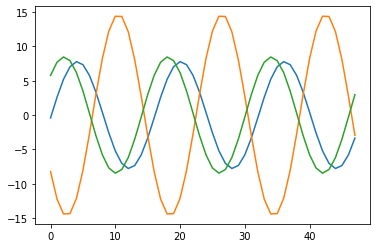

In [37]:
plt.plot(cp.asnumpy(cp.tile(Ret[0,:],3)))
plt.plot(cp.asnumpy(cp.tile(Ret[1,:],3)))
plt.plot(cp.asnumpy(cp.tile(Ret[2,:],3)))

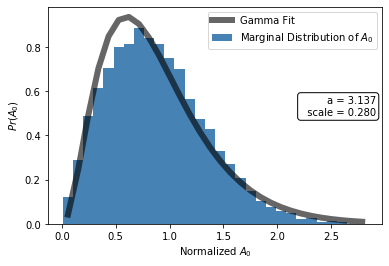

In [111]:
# Data processing
# Fit with gamma functions
y=Amps[2,:]
z=totAmps[0,:]
y=y/(cp.mean(z)/3)
#y=y/cp.mean(y)
y=cp.asnumpy(cp.sqrt(y))


plt.figure(figsize=(6,4))
# Histogram
Pr,bins,fig=plt.hist(y,30,density=True,label="Marginal Distribution of $A_{0}$",color="steelblue");
midbins = numpy.diff(bins)/2.+bins[:-1]

# curve fit
a,loc,scale = ss.gamma.fit(y,floc=0)
Pr_fit = ss.gamma.pdf(x=midbins,a=a,loc=loc,scale=scale)

plt.plot(midbins,Pr_fit,'black',linewidth=6,alpha=0.6,label='Gamma Fit')
plt.annotate(s="a = %.3f\n  scale = %.3f"%(a,scale),
             horizontalalignment="right",
         bbox=dict(boxstyle="round",fc="w"),xy=(0.98,0.5),xycoords='axes fraction',size=10)
plt.xlabel("Normalized $A_0$")
plt.ylabel("$Pr(A_0)$")
plt.legend()
#plt.savefig('GammaFit.pdf')

In [ ]:
# comparing different models
# Assuming sqrt(A0x**2 + A0y**2 + A0z**2 ) = 1

In [240]:
size = 10000
omegat = cr.uniform(size=size)*2*cp.pi

# old model
ra_p = cr.uniform(size=size)*2*cp.pi
sin_dec_p = cr.uniform(size=size)*2-1
dec_p = cp.arcsin(sin_dec_p)
n_p = cp.array([cp.cos(dec_p)*cp.cos(ra_p),cp.cos(dec_p)*cp.sin(ra_p),cp.sin(dec_p)])
phase_p = cr.uniform(size=size)*2*cp.pi

ra_e = cr.uniform(size=size)*2*cp.pi
sin_dec_e = cr.uniform(size=size)*2-1
dec_e = cp.arcsin(sin_dec_e)
n_e = cp.array([cp.cos(dec_e)*cp.cos(ra_e),cp.cos(dec_e)*cp.sin(ra_e),cp.sin(dec_e)])
phase_e = cr.uniform(size=size)*2*cp.pi

ra_pos = cr.uniform(size=size)*2*cp.pi
sin_dec_pos = cr.uniform(size=size)*2-1
dec_pos = cp.arcsin(sin_dec_pos)
n_pos = cp.array([cp.cos(dec_pos)*cp.cos(ra_pos),cp.cos(dec_pos)*cp.sin(ra_pos),cp.sin(dec_pos)])





# new model

normAp = cr.gamma(3.141,0.282,size)/cp.sqrt(3)
normAe = cr.gamma(3.141,0.282,(3,size))/cp.sqrt(3)
phase_e_vec = cr.uniform(size=(3,size))*2*cp.pi
phase_p = cr.uniform(size=size)*2*cp.pi

In [248]:
dt_uncorr = cp.sum(n_p*n_pos,axis=0)*cp.sin(omegat + phase_p) - cp.sum(n_e*n_pos,axis=0)*cp.sin(omegat + phase_e)
dt_corr = cp.sum(n_e*n_pos,axis=0)*cp.sin(omegat + phase_p) - cp.sum(n_e*n_pos,axis=0)*cp.sin(omegat + phase_e)

dt_gamma = normAp * cp.sin(omegat + phase_p) - cp.sum(cp.sin(cp.tile(omegat,(3,1)) + phase_e_vec)*normAe,axis=0)

dt_gamma_fun = normAp * cp.sin(omegat + phase_p) - cp.sum(normAe*n_pos,axis=0)*cp.sin(omegat + phase_e_vec[0,:])

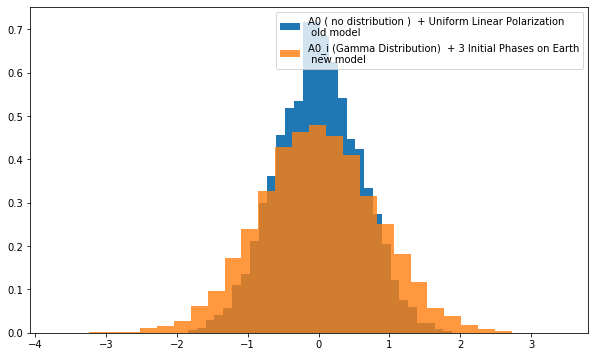

In [252]:
plt.figure(figsize=(10,6))
plt.hist(cp.asnumpy(dt_uncorr),30,alpha=1,density=True,label="A0 ( no distribution )  + Uniform Linear Polarization\n old model")
plt.hist(cp.asnumpy(dt_gamma),30,alpha=0.8,density=True,label="A0_i (Gamma Distribution)  + 3 Initial Phases on Earth\n new model")
plt.legend()
#plt.savefig('delta_t')

In [ ]:
# Check the linear combination of A_i
# Ak=np.sqrt((Ax**2+Ay**2+2*Ax*Ay*np.sin(Phix+Phiy))/2.)

In [ ]:
'''
COHERENCE

Check the space coherence
'''
vp=1e-3
log10m = -22
m=10**log10m

t_corr = 2*cp.pi/m
l_dB = 2*cp.pi/m/vp
#ev2kpc = 3.0857e19 /1.973e-7


nPoints = 16

tx = cp.zeros((4,nPoints))
tlist= cp.linspace(0,1,nPoints+1)
tx[0,:] = tlist[:-1]*t_corr

ty = cp.zeros((4,nPoints))
ty[0,:] = tlist[:-1]*t_corr
ty[1,:] = cp.tile(l_dB,nPoints)*0.08

nParticles = 2**10
output=[]

nSimulation= 100000
Amps_x = cp.ndarray((3,nSimulation))
Phis_x = cp.ndarray((3,nSimulation))
Amps_y = cp.ndarray((3,nSimulation))
Phis_y = cp.ndarray((3,nSimulation))

'''
Main:
'''
for i in tqdm(range(nSimulation)):
    v,a,p=vec_particle_gen(vp,nParticles)

    # Physical values   
    m = 10**log10m # eV
    K = m*v

    # From K to omega
    omega = cp.ndarray((1,1,nParticles))
    omega[0,:,:] = cp.sqrt(cp.sum(K*K,axis=0)+m**2)

    #Retx(3,nPoints)

    Ret_x = vector_random_walk(tx,omega,K,a,p)
    Ret_y = vector_random_walk(ty,omega,K,a,p)
    
    #results(3,nSimulation)
    Amps_x[:,i] = 2 * cp.sum(Ret_x*Ret_x,axis=1)/nPoints #  mean value over time
    Phis_x[0,i] = tlist[cp.where(cp.max(Ret_x[0]) == Ret_x[0])[0][0]]*2*cp.pi
    Phis_x[1,i] = tlist[cp.where(cp.max(Ret_x[1]) == Ret_x[1])[0][0]]*2*cp.pi
    Phis_x[2,i] = tlist[cp.where(cp.max(Ret_x[2]) == Ret_x[2])[0][0]]*2*cp.pi
    
    Amps_y[:,i] = 2 * cp.sum(Ret_y*Ret_y,axis=1)/nPoints #  mean value over time
    Phis_y[0,i] = tlist[cp.where(cp.max(Ret_y[0]) == Ret_y[0])[0][0]]*2*cp.pi
    Phis_y[1,i] = tlist[cp.where(cp.max(Ret_y[1]) == Ret_y[1])[0][0]]*2*cp.pi
    Phis_y[2,i] = tlist[cp.where(cp.max(Ret_y[2]) == Ret_y[2])[0][0]]*2*cp.pi


In [ ]:
'''
Calculate the correlation !!!
'''

a = Amps_x[0,:]
b = Amps_y[0,:]
c = Amps_y[1,:]
d = Phis_x[0,:]
e = Phis_y[0,:]
f = Phis_y[1,:]
results=[]
for (x2,y2) in [(a,b),(a,c),(d,e),(d,f),(a,e),(a,f)]:

    x = cp.sqrt(x2)
    y = cp.sqrt(y2)

    m_x2 = cp.mean(x2)
    m_x = cp.mean(x)
    m_y2 = cp.mean(y2)
    m_y = cp.mean(y)

    sig_x = cp.sqrt(m_x2-m_x**2)
    sig_y = cp.sqrt(m_y2-m_y**2)

    results.append(cp.mean((x-m_x)*(y-m_y))/sig_x/sig_y)

print(results)

In [ ]:
kpc2nat = 3.0857e19 /1.973e-7


l = 0.5*kpc2nat/(2*cp.pi/10**(-21.5)/vp)
print("%.3f"%(l))

In [ ]:
corr = cp.ndarray((10,6))
Dis = cp.array([0.01,0.02,0.04,0.08,0.16,0.32,0.64,1.28,2.56,5.12])

corr[0,:] = cp.array([0.9976607022205033, 0.0037676705818899463, 0.9327020080089024, 0.007450448389243849, -0.009171508248407718, 0.005356242440316161])
corr[1,:] = cp.array([0.99106258203287, 0.011099269792954449, 0.9012317040062288, 0.004039380559944105, -0.0034537435583275934, 0.004679418272634157])
corr[2,:] = cp.array([0.9643100923845139, -0.000992748126691237, 0.7965985256746666, -0.01105591066757477, 0.00970309745521556, 0.009073964597856511])
corr[3,:] = cp.array([0.8623397830753567, 0.007114731531677067, 0.6580210721689032, 0.006986199182822402, -0.001957350351134233, 0.013300395224419708])
corr[4,:] = cp.array([0.5721820929063567, -0.007412828990754051, 0.43119528453945477, -0.0036480322991355608, 0.005106476076536831, -0.003291443323211755])
corr[5,:] = cp.array([0.11629739390099995, 0.0059398877230059325, 0.17160920059913792, -0.007730739043007247, -0.015587786942008451, 0.004431751607055087])
corr[6,:] = cp.array([0.0004846887852723556, 0.00923196440467667, 0.008129350252005289, 0.002672610405310479, -0.014295219328776707, 0.014190959985873657])
corr[7,:] = cp.array([0.007517423340686037, 0.020655454466178978, -0.0008678267229125785, 0.005190865100771142, -0.018050857571350856, 0.004259351720611055])
corr[8,:] = cp.array([-0.009911551109561472, 0.019040773634095867, -0.004305765239621097, -0.008191116532864086, 0.00571505800291175, -0.021481308743130006])
corr[9,:] = cp.array([0.00997750749582416, 0.012745851516836933, -0.008872693213043598, 0.0048421096593427556, 0.00752769696005557, 0.0009189869377229605])




perc235=cp.array([0.039,0.118])
perc23=cp.array([0.124,0.373])
perc225=cp.array([0.393,1.181])
perc22=cp.array([1.245,3.734])




In [ ]:
corr = cp.asnumpy(corr)
Dis = cp.asnumpy(Dis)
perc235 = cp.asnumpy(perc235)
perc23 = cp.asnumpy(perc23)
perc225 = cp.asnumpy(perc225)
perc22 = cp.asnumpy(perc22)

plt.figure(figsize=(6,4))
ll = -0.1
hl = 1.19
lel = 10**-1.8
ril = 10**0.7
plt.ylim([ll,hl])
plt.xlim([lel,ril])

plt.semilogx(Dis,corr[:,0],label="$A_{0,x},A_{0,x}$",linewidth=3);
plt.semilogx(Dis,corr[:,1],label="$A_{0,x},A_{0,y}$",linewidth=3);
plt.semilogx(Dis,corr[:,2],label="$\phi_{x},\phi_{x}$",linewidth=3);
plt.semilogx(Dis,corr[:,3],label="$\phi_{x},\phi_{y}$",linewidth=3);
plt.semilogx(Dis,corr[:,4],label="$A_{0,x},\phi_{x}$",linewidth=3);
plt.semilogx(Dis,corr[:,5],label="$A_{0,x},\phi_{y}$",linewidth=3);

plt.plot([lel,ril],[0,0],'k--')
plt.plot([lel,ril],[1,1],'k--')

plt.fill_between(perc235,[hl,hl],[ll,ll],facecolor='gold',alpha=0.2)
plt.fill_between(perc23,[hl,hl],[ll,ll],facecolor='gold',alpha=0.3)
plt.fill_between(perc225,[hl,hl],[ll,ll],facecolor='gold',alpha=0.4)
plt.fill_between(perc22,[hl,hl],[ll,ll],facecolor='gold',alpha=0.5)


plt.annotate("$m =$",horizontalalignment="right",xy=[perc235[0]*0.9,1.05],xycoords='data',size=15)
plt.annotate("$10^{-23.5}$eV",horizontalalignment="left",xy=[perc235[0],1.05],xycoords='data',size=12)
plt.annotate("$10^{-23}$eV",horizontalalignment="left",xy=[perc23[0],1.05],xycoords='data',size=12)
plt.annotate("$10^{-22.5}$eV",horizontalalignment="left",xy=[perc225[0],1.05],xycoords='data',size=12)
plt.annotate("$10^{-22}$eV",horizontalalignment="left",xy=[perc22[0],1.05],xycoords='data',size=12)



plt.xlabel("$|x-y|/\lambda_{dB}$")
plt.ylabel("$corr(X,Y)$")
plt.legend()
plt.savefig('SpatialCorr.pdf')